In [2]:
# Libraries
import numpy as np
from matplotlib import pyplot as plt
import gpvisc
import pandas as pd
from scipy.optimize import minimize

# load the model
device = gpvisc.get_device()
gp_model, likelihood = gpvisc.load_gp_model(model_number=1, device=device)

Will run on cuda


/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/models.py:270: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  X_train_valid = torch.load(model_path /

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1265: RuntimeWarning: invalid value encountered in power
  F = (1 - xi) * erf(np.sqrt(np.pi) / (2 * (1 - xi)) * r_phy * (1 + r_phy**gamma))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1266: RuntimeWarning: invalid value encountered in power
  eta_r = (1 + r_phy**delta) / ((1 - F) ** (B * phy_star))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1265: RuntimeWarning: invalid value encountered in power
  F = (1 - xi) * erf(np.sqrt(np.pi) / (2 * (1 - xi)) * r_phy * (1 + r_phy**gamma))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1266: RuntimeWarning: invalid value encountered in power
  eta_r = (1 + r_phy**delta) / ((1 - F) ** (B * phy_star))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1265: RuntimeWarning: invalid value encountered in power
  F = (1 - xi) * erf(

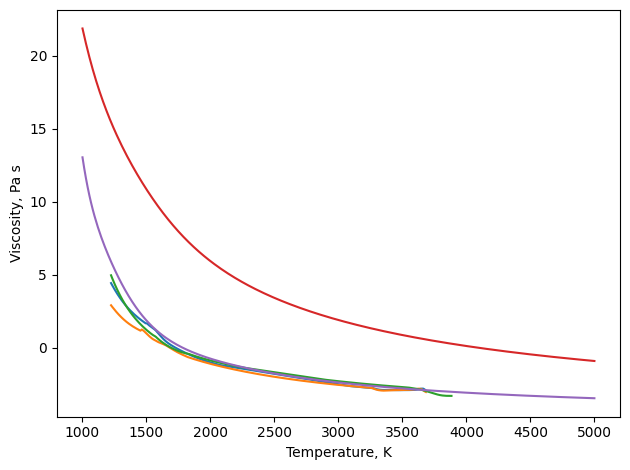

In [4]:
db_list = []
X_in_list = []
visco_mean_list = []
magma_visco_list = []

# get the magma viscosity curves for the three different cases
for i in ["BSE_1bar", "FBSE_1bar", "CAI_1bar"]:

    C_1bar_in = pd.read_excel("./additional_data/Silicate_condensation_tests.xlsx", sheet_name=i)
    C_1bar_mol = gpvisc.wt_mol(gpvisc.chimie_control(C_1bar_in))
    C_1bar_mol["prct_c"] = 100 -C_1bar_mol["prct_l"]-C_1bar_mol["prct_g"] 

    # calculate the input for the GP
    X_in = gpvisc.scale_for_gaussianprocess(C_1bar_mol["T_K"],
                                            0.0*C_1bar_mol["T_K"],
                                            C_1bar_mol)

    # predictions of the GP
    visco_mean, visco_std = gpvisc.predict(X_in, gp_model, likelihood)

    # adding the effect of crystals
    magma_visco = gpvisc.viscosity_melt_ctx(visco_mean, C_1bar_mol["T_K"], C_1bar_mol.prct_c.values/100, phy_m=0.62)

    db_list.append(C_1bar_mol)
    X_in_list.append(X_in)
    visco_mean_list.append(visco_mean)
    magma_visco_list.append(magma_visco)

###
# LIQUID ENDMEMBERS
###

## SILICA
db_sio2 = gpvisc.generate_query_single(sio2=100.0,
                                     composition_mole = True,
                                     T_init = 1000.0, T_final= 5000.0,
                                     nb_values = 300,
                                     )
X_sio2 = gpvisc.scale_for_gaussianprocess(db_sio2["T"],
                                          db_sio2["P"],
                                          db_sio2)
visco_sio2, visco_sio2_std = gpvisc.predict(X_sio2, gp_model, likelihood)

## ENSTATITE
db_mgsio3 = gpvisc.generate_query_single(sio2=50.0,
                                          mgo=50.0,
                                          composition_mole = True,
                                          T_init = 1000.0, T_final= 5000.0,
                                          nb_values = 300,
                                         )
X_mgsio3 = gpvisc.scale_for_gaussianprocess(db_mgsio3["T"],
                                             db_mgsio3["P"],
                                             db_mgsio3)
visco_mgsio3, visco_mgsio3_std = gpvisc.predict(X_mgsio3, gp_model, likelihood)

plt.figure()
for i in range(3):
    plt.plot(db_list[i]["T_K"], visco_mean_list[i])

plt.plot(db_sio2["T"], visco_sio2)
plt.plot(db_mgsio3["T"], visco_mgsio3)

plt.xlabel("Temperature, K")
plt.ylabel("Viscosity, Pa s")
plt.tight_layout()

In [5]:
## Common parameters and functions

# Constant values
sigma = 5.670374419e-08 # Stefan B constant
G = 6.67E-11 # Gravitational constant
Radius_K2141b = 1.51*6371.0e3 # radius from https://science.nasa.gov/exoplanet-catalog/k2-141-b/
Mass_K2141b = 4.97*5.972e24 # mass from https://science.nasa.gov/exoplanet-catalog/k2-141-b/
g = G*Mass_K2141b/(Radius_K2141b**2) # acceleration of gravity
print("Gravity acceleration (m/(s*s)): {:.2f}".format(g))

def Ra(Ts, Ti, mu): # Thermal Rayleigh Number
    dT = Ti-Ts
    return rho0*alf*dT*g*L**3/D/mu

def Pr(mu): # Prandl number
    return mu/(rho0*D)

def surface_temperature(Ts, Ti, mu): # We balance a radiating heat flux with and a convecting heat flux.
    dT = Ti-Ts
    return (prefix*k*dT*(Ra(Ts, Ti, mu)**a)*(Pr(mu)**b)/sigma/L)**(1./4.)

def objective(Ts, Ti, mu):
    return (surface_temperature(Ts, Ti, mu)-Ts)**2

def resolve_Ts(Ti_, mu_):
    Ts_out = np.zeros(len(Ti_))
    for i in range(len(Ti_)):

        Ti = Ti_[i]
        mu = 10**mu_[i]
        res = minimize(objective, Ti-200.0, args=(Ti, mu))
        Ts_out[i] = res.x[0]
    return Ts_out

def generate_parameters(convection_type, rho_init = 4.0e3):

    if convection_type == "soft":
        prefix = 0.22 # Solomatov 2000
        a = 2.0/7.0 # Power exponent heat flux, vertical convection, soft
        b = -1.0/7.0
    elif convection_type == "hard":
        prefix = 0.089 # Solomatov 2000
        a = 1.0/3.0 # Power exponent heat flux, vertical convection, hard
        b = 0.0
    elif convection_type == "horizontal":
        prefix = 1.0
        a = 1.0/5.0 # Power exponent heat flux, horizontal convection
        b = 0.0

    # Thermal diffusivity, normal distribution
    # Average value in agreement with melt data 
    # from Eriksson et al. 2003
    # and rock data from Gibert et al. 2003
    # normal distribution with 40% error
    D = 5.0e-07 + 2e-7*np.random.randn() 

    # Coefficient of thermal expansion, normal distribution
    # average value in agreement with Suzuki et al. 1998 data
    # on peridotite melt (we assume peridotite rocks will be similar)
    # normal distribution with 10% error
    alf = 6.0e-05 + 6e-6*np.random.randn() 

    # average melt density Kg/m^3
    # Suzuki et al. 1998 data
    # also Petitgirard et al. 2015 for MgSiO3 at 40 GPa...
    # normal distribution with 10% error
    rho0 = rho_init + 0.4e3*np.random.randn() 

    # average melt heat capacity at 2000 K, J Kg-1 K-1
    # normal distribution with 10% error
    Cp = 1500.0 + 150.0*np.random.randn()
    k = D*rho0*Cp # thermal conductivity

    # critical crystal fraction
    # normal distribution with 10% error
    phy_m = np.random.randn()*0.06+0.6 

    return prefix, a, b, D, alf, rho0, Cp, k, phy_m
    

def remove_columns_with_nan(arr):
    # Check which columns have NaN values
    columns_with_nan = np.isnan(arr).any(axis=0)

    # Invert the condition to get columns without NaN values
    columns_without_nan = ~columns_with_nan

    # Keep only the columns without NaN values
    arr_filtered = arr[:, columns_without_nan]

    return arr_filtered

Gravity acceleration (m/(s*s)): 21.39


## Hard convection

In [8]:
# start sampling loop
n_samples = 200

# get interior temperatures = temperature of the viscosity curves
interior_temperature_BSE = db_list[0]["T_K"]
interior_temperature_FBSE = db_list[1]["T_K"]
interior_temperature_CAI = db_list[2]["T_K"]
interior_temperature_SIO2 = db_sio2["T"]
interior_temperature_MGSIO3 = db_mgsio3["T"]

# prepare list to save the surface temperatures
surface_temperature_BSE = []
surface_temperature_FBSE = []
surface_temperature_CAI = []
surface_temperature_SIO2 = []
surface_temperature_MGSIO3 = []

# start sampling
# sampling possible values from uniform and gaussian distributions
for j in range(n_samples):

    # get parameters (sampling)
    prefix, a, b, D, alf, rho0, Cp, k, phy_m = generate_parameters("hard")

    # Height of the molten layer, fixed
    L = 4000.0e3

    # calculate magma visco & adding the effect of crystals
    magma_visco_0 = gpvisc.viscosity_melt_ctx(visco_mean_list[0], db_list[0]["T_K"].values, db_list[0].prct_c.values/100, phy_m=phy_m)
    magma_visco_1 = gpvisc.viscosity_melt_ctx(visco_mean_list[1], db_list[1]["T_K"].values, db_list[1].prct_c.values/100, phy_m=phy_m)
    magma_visco_2 = gpvisc.viscosity_melt_ctx(visco_mean_list[2], db_list[2]["T_K"].values, db_list[2].prct_c.values/100, phy_m=phy_m)

    T_surf_0 = resolve_Ts(db_list[0]["T_K"].values, magma_visco_0)
    T_surf_1 = resolve_Ts(db_list[1]["T_K"].values, magma_visco_1)
    T_surf_2 = resolve_Ts(db_list[2]["T_K"].values, magma_visco_2)
    T_surf_MGSIO3 = resolve_Ts(db_mgsio3["T"].values, visco_mgsio3)
    # initial density for SiO2 at 10 GPa from Guerette et al. 2015. Sci Rep 5, 15343. https://doi.org/10.1038/srep15343
    prefix, a, b, D, alf, rho0, Cp, k, phy_m = generate_parameters("hard", rho_init=2750.0)
    T_surf_SIO2 = resolve_Ts(db_sio2["T"].values, visco_sio2)
   

    surface_temperature_BSE.append(T_surf_0)
    surface_temperature_FBSE.append(T_surf_1)
    surface_temperature_CAI.append(T_surf_2)
    surface_temperature_SIO2.append(T_surf_SIO2)
    surface_temperature_MGSIO3.append(T_surf_MGSIO3)

# SANITY CHECK : WE REMOVE SAMPLES WITH NAN VALUES
surface_temperature_BSE = remove_columns_with_nan(np.array(surface_temperature_BSE).T)
surface_temperature_FBSE = remove_columns_with_nan(np.array(surface_temperature_FBSE).T)
surface_temperature_CAI = remove_columns_with_nan(np.array(surface_temperature_CAI).T)
surface_temperature_SIO2 = remove_columns_with_nan(np.array(surface_temperature_SIO2).T)
surface_temperature_MGSIO3 = remove_columns_with_nan(np.array(surface_temperature_MGSIO3).T)

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1265: RuntimeWarning: invalid value encountered in power
  F = (1 - xi) * erf(np.sqrt(np.pi) / (2 * (1 - xi)) * r_phy * (1 + r_phy**gamma))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1266: RuntimeWarning: invalid value encountered in power
  eta_r = (1 + r_phy**delta) / ((1 - F) ** (B * phy_star))
/tmp/ipykernel_3714784/2361783637.py:20: RuntimeWarning: invalid value encountered in power
  return (prefix*k*dT*(Ra(Ts, Ti, mu)**a)*(Pr(mu)**b)/sigma/L)**(1./4.)


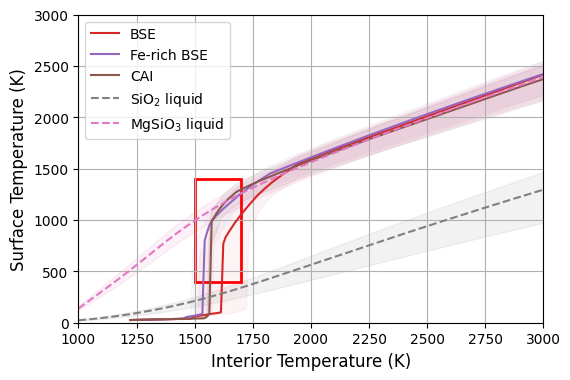

In [9]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(6,4))
ax = plt.subplot()

# PLANETARY COMPOSITIONS
plt.plot(interior_temperature_BSE, np.median(surface_temperature_BSE, axis=1), "-", color="C3", label="BSE")
plt.fill_between(interior_temperature_BSE, 
                 np.quantile(surface_temperature_BSE, 0.025, axis=1),
                 np.quantile(surface_temperature_BSE, 0.975, axis=1), color="C3", alpha=0.05)
plt.plot(interior_temperature_FBSE, np.median(surface_temperature_FBSE, axis=1), "-", color="C4", label="Fe-rich BSE")
plt.fill_between(interior_temperature_FBSE, 
                 np.quantile(surface_temperature_FBSE, 0.025, axis=1),
                 np.quantile(surface_temperature_FBSE, 0.975, axis=1), color="C4", alpha=0.05)
plt.plot(interior_temperature_CAI, np.median(surface_temperature_CAI, axis=1), "-", color="C5", label="CAI")
plt.fill_between(interior_temperature_CAI, 
                 np.quantile(surface_temperature_CAI, 0.025, axis=1),
                 np.quantile(surface_temperature_CAI, 0.975, axis=1), color="C5", alpha=0.1)

# EXTREME COMPOSITIONS
plt.plot(interior_temperature_SIO2, np.median(surface_temperature_SIO2, axis=1), "--", color="grey", label="SiO$_2$ liquid")
plt.fill_between(interior_temperature_SIO2, 
                 np.quantile(surface_temperature_SIO2, 0.025, axis=1),
                 np.quantile(surface_temperature_SIO2, 0.975, axis=1), color="grey", alpha=0.1)

plt.plot(interior_temperature_MGSIO3, np.median(surface_temperature_MGSIO3, axis=1), "--", color="C6", label="MgSiO$_3$ liquid")
plt.fill_between(interior_temperature_MGSIO3, 
                 np.quantile(surface_temperature_MGSIO3, 0.025, axis=1),
                 np.quantile(surface_temperature_MGSIO3, 0.975, axis=1), color="C6", alpha=0.1)

plt.xlabel('Interior Temperature (K)', fontsize=12)
plt.ylabel('Surface Temperature (K)', fontsize=12)
#plt.plot([1000,3000.], [956,956], "--")
plt.legend(loc="best")
rectangle = Rectangle((1500,400), # position of lower left corner
                      200, # width
                      1000, # height
                      linewidth=2,  # Line width
                      edgecolor='r',  # Edge color
                      facecolor='none'
)
ax.add_patch(rectangle)
plt.xlim(1000, 3000)
plt.ylim(0, 3000)
plt.grid()
plt.savefig("./figures/Surface_Interior_Hard.pdf")


## Horizontal case

In [10]:
# get interior temperatures = temperature of the viscosity curves
interior_temperature_BSE = db_list[0]["T_K"]
interior_temperature_FBSE = db_list[1]["T_K"]
interior_temperature_CAI = db_list[2]["T_K"]
interior_temperature_SIO2 = db_sio2["T"]
interior_temperature_MGSIO3 = db_mgsio3["T"]

# prepare list to save the surface temperatures
surface_temperature_BSE = []
surface_temperature_FBSE = []
surface_temperature_CAI = []
surface_temperature_SIO2 = []
surface_temperature_MGSIO3 = []

# start sampling
# sampling possible values from uniform and gaussian distributions
for j in range(n_samples):

    # get parameters (sampling)
    prefix, a, b, D, alf, rho0, Cp, k, phy_m = generate_parameters("horizontal")

    # Height of the molten layer, fixed
    L = 4000.0e3

    # calculate magma visco
    # adding the effect of crystals
    magma_visco_0 = gpvisc.viscosity_melt_ctx(visco_mean_list[0], db_list[0]["T_K"].values, db_list[0].prct_c.values/100, phy_m=phy_m)
    magma_visco_1 = gpvisc.viscosity_melt_ctx(visco_mean_list[1], db_list[1]["T_K"].values, db_list[1].prct_c.values/100, phy_m=phy_m)
    magma_visco_2 = gpvisc.viscosity_melt_ctx(visco_mean_list[2], db_list[2]["T_K"].values, db_list[2].prct_c.values/100, phy_m=phy_m)

    #
    T_surf_0 = resolve_Ts(db_list[0]["T_K"].values, magma_visco_0)
    T_surf_1 = resolve_Ts(db_list[1]["T_K"].values, magma_visco_1)
    T_surf_2 = resolve_Ts(db_list[2]["T_K"].values, magma_visco_2)
    T_surf_SIO2 = resolve_Ts(db_sio2["T"].values, visco_sio2)
    T_surf_MGSIO3 = resolve_Ts(db_mgsio3["T"].values, visco_mgsio3)

    surface_temperature_BSE.append(T_surf_0)
    surface_temperature_FBSE.append(T_surf_1)
    surface_temperature_CAI.append(T_surf_2)
    surface_temperature_SIO2.append(T_surf_SIO2)
    surface_temperature_MGSIO3.append(T_surf_MGSIO3)

# SANITY CHECK : WE REMOVE SAMPLES WITH NAN VALUES
surface_temperature_BSE = remove_columns_with_nan(np.array(surface_temperature_BSE).T)
surface_temperature_FBSE = remove_columns_with_nan(np.array(surface_temperature_FBSE).T)
surface_temperature_CAI = remove_columns_with_nan(np.array(surface_temperature_CAI).T)
surface_temperature_SIO2 = remove_columns_with_nan(np.array(surface_temperature_SIO2).T)
surface_temperature_MGSIO3 = remove_columns_with_nan(np.array(surface_temperature_MGSIO3).T)

/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1265: RuntimeWarning: invalid value encountered in power
  F = (1 - xi) * erf(np.sqrt(np.pi) / (2 * (1 - xi)) * r_phy * (1 + r_phy**gamma))
/home/charles/miniconda3/envs/gpvisc/lib/python3.11/site-packages/gpvisc/utils.py:1266: RuntimeWarning: invalid value encountered in power
  eta_r = (1 + r_phy**delta) / ((1 - F) ** (B * phy_star))


/tmp/ipykernel_3714784/2361783637.py:20: RuntimeWarning: invalid value encountered in power
  return (prefix*k*dT*(Ra(Ts, Ti, mu)**a)*(Pr(mu)**b)/sigma/L)**(1./4.)


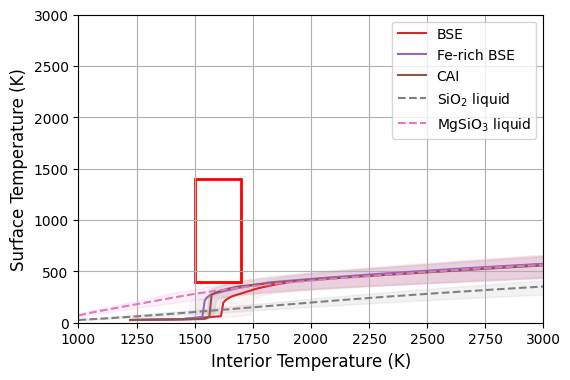

In [11]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(6,4))
ax = plt.subplot()

# PLANETARY COMPOSITIONS
plt.plot(interior_temperature_BSE, np.median(surface_temperature_BSE, axis=1), "-", color="C3", label="BSE")
plt.fill_between(interior_temperature_BSE, 
                 np.quantile(surface_temperature_BSE, 0.025, axis=1),
                 np.quantile(surface_temperature_BSE, 0.975, axis=1), color="C3", alpha=0.05)
plt.plot(interior_temperature_FBSE, np.median(surface_temperature_FBSE, axis=1), "-", color="C4", label="Fe-rich BSE")
plt.fill_between(interior_temperature_FBSE, 
                 np.quantile(surface_temperature_FBSE, 0.025, axis=1),
                 np.quantile(surface_temperature_FBSE, 0.975, axis=1), color="C4", alpha=0.05)
plt.plot(interior_temperature_CAI, np.median(surface_temperature_CAI, axis=1), "-", color="C5", label="CAI")
plt.fill_between(interior_temperature_CAI, 
                 np.quantile(surface_temperature_CAI, 0.025, axis=1),
                 np.quantile(surface_temperature_CAI, 0.975, axis=1), color="C5", alpha=0.1)

# EXTREME COMPOSITIONS
plt.plot(interior_temperature_SIO2, np.median(surface_temperature_SIO2, axis=1), "--", color="grey", label="SiO$_2$ liquid")
plt.fill_between(interior_temperature_SIO2, 
                 np.quantile(surface_temperature_SIO2, 0.025, axis=1),
                 np.quantile(surface_temperature_SIO2, 0.975, axis=1), color="grey", alpha=0.1)

plt.plot(interior_temperature_MGSIO3, np.median(surface_temperature_MGSIO3, axis=1), "--", color="C6", label="MgSiO$_3$ liquid")
plt.fill_between(interior_temperature_MGSIO3, 
                 np.quantile(surface_temperature_MGSIO3, 0.025, axis=1),
                 np.quantile(surface_temperature_MGSIO3, 0.975, axis=1), color="C6", alpha=0.1)

plt.xlabel('Interior Temperature (K)', fontsize=12)
plt.ylabel('Surface Temperature (K)', fontsize=12)
#plt.plot([1000,3000.], [956,956], "--")
plt.legend(loc="best")
rectangle = Rectangle((1500,400), # position of lower left corner
                      200, # width
                      1000, # height
                      linewidth=2,  # Line width
                      edgecolor='r',  # Edge color
                      facecolor='none'
)
ax.add_patch(rectangle)
plt.xlim(1000, 3000)
plt.ylim(0, 3000)
plt.grid()
plt.savefig("./figures/Surface_Interior_Horizontal.pdf")
